<font face = "Computer Modern", size = 3>
<ul> To Do List
    <li> -X- Check how noise scales with mean </li>
    <li> -X- Look at a histogram of pixel values of the natural images... maybe subtract the mean, and scale by STD? </li>
    <li> -X- Add history filter to the design matrix </li>
    <li> -X- Be really sure about what you're doing in terms of selecting cells. </li>
    <li> -X- Want about 5 cells with good orientation selectivity, good receptive field, and strong responses to natural scenes. </li>
    <li> -X- Use fast oopsi to deconvolve to spikes (for poisson) </li>
    <li> -X- Try deconvolving to 'rate' </li>
    <li> Hyper-parameter search over learning rate, regularization, and initialization of scale and offset parameters for *each* GLM (poisson, gamma, and gaussian) </li>
    <li> -X- TRY initialization small random weights </li>
    <li> -X- Make held out data ~10 trials per image, and then look at "trial averaged" traces. (This didn't make much sense)
    </ul>
    

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import glm_model as gm
from glm_utils import *
from scipy.stats import linregress

import pprint

%load_ext autoreload
%autoreload 2
%matplotlib inline
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
boc = BrainObservatoryCache(manifest_file='boc/manifest.json')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import pandas as pd

# Download experiment containers for VISp experiments
visp_ecs = boc.get_experiment_containers(targeted_structures=['VISp'])
print("all VISp experiment containers: %d" % len(visp_ecs))

# Download cells for a set of experiments and convert to DataFrame
cells = boc.get_cell_specimens()
cells = pd.DataFrame.from_records(cells)
print("total cells: %d" % len(cells))
# find direction selective cells in VISp
visp_ec_ids = [ ec['id'] for ec in visp_ecs ]
visp_cells = cells[cells['experiment_container_id'].isin(visp_ec_ids)]
print("VISp cells: %d" % len(visp_cells))

# significant response to drifting gratings stimulus
sig_cells = visp_cells[visp_cells['p_dg'] < 0.05]
print("cells with sig. response to drifting gratings: %d" % len(sig_cells))

# direction selective cells
dsi_cells = sig_cells[(sig_cells['dsi_dg'] > 0.5) & (sig_cells['dsi_dg'] < 1.5)]
print("direction-selective cells: %d" % len(dsi_cells))

ns_cells = dsi_cells[(dsi_cells['time_to_peak_ns'] < .3) & (dsi_cells['time_to_peak_ns'] > .05)]

print("Cells that 'like' natural scenes: %d" % len(ns_cells))


all VISp experiment containers: 25
total cells: 18260
VISp cells: 7167
cells with sig. response to drifting gratings: 4179
direction-selective cells: 2257
Cells that 'like' natural scenes: 1209


In [5]:
ns_cells


,area,cell_specimen_id,dsi_dg,experiment_container_id,imaging_depth,osi_dg,osi_sg,p_dg,p_ns,p_sg,...,pref_sf_sg,pref_tf_dg,time_to_peak_ns,time_to_peak_sg,tld1_id,tld1_name,tld2_id,tld2_name,tlr1_id,tlr1_name
385,VISp,517397377,1.176431,511498742,350,1.317674,1.070871,7.288761e-03,1.429351e-07,1.556623e-12,...,0.04,2,0.29925,0.29925,177837516,Scnn1a-Tg3-Cre,177837320,Camk2a-tTA,265943423,Ai93(TITL-GCaMP6f)
389,VISp,517397393,0.526651,511498742,350,0.902515,1.758233,2.985287e-20,2.617489e-09,4.088509e-02,...,0.04,1,0.23275,0.26600,177837516,Scnn1a-Tg3-Cre,177837320,Camk2a-tTA,265943423,Ai93(TITL-GCaMP6f)
390,VISp,517397398,0.881830,511498742,350,1.761959,0.338153,4.047447e-04,5.844738e-35,7.344986e-16,...,0.02,1,0.19950,0.26600,177837516,Scnn1a-Tg3-Cre,177837320,Camk2a-tTA,265943423,Ai93(TITL-GCaMP6f)
392,VISp,517397407,1.141105,511498742,350,1.755176,0.987837,1.009472e-04,2.113473e-21,3.437841e-04,...,0.08,1,0.16625,0.36575,177837516,Scnn1a-Tg3-Cre,177837320,Camk2a-tTA,265943423,Ai93(TITL-GCaMP6f)
394,VISp,517397417,0.564934,511498742,350,0.762581,0.858267,1.879031e-08,4.129234e-104,1.724902e-06,...,0.04,1,0.26600,0.26600,177837516,Scnn1a-Tg3-Cre,177837320,Camk2a-tTA,265943423,Ai93(TITL-GCaMP6f)
403,VISp,517397459,1.316833,511498742,350,1.071293,0.304371,6.895258e-05,1.492557e-21,4.339291e-06,...,0.32,1,0.26600,0.23275,177837516,Scnn1a-Tg3-Cre,177837320,Camk2a-tTA,265943423,Ai93(TITL-GCaMP6f)
405,VISp,517397469,0.638355,511498742,350,2.144197,1.319288,5.945769e-08,2.633289e-15,2.681335e-03,...,0.32,8,0.06650,0.16625,177837516,Scnn1a-Tg3-Cre,177837320,Camk2a-tTA,265943423,Ai93(TITL-GCaMP6f)
419,VISp,517397534,1.459588,511498742,350,0.376618,1.539551,1.277762e-02,2.071754e-40,3.821011e-04,...,0.08,15,0.26600,0.23275,177837516,Scnn1a-Tg3-Cre,177837320,Camk2a-tTA,265943423,Ai93(TITL-GCaMP6f)
422,VISp,517397549,1.489874,511498742,350,1.224863,0.663162,2.920332e-02,1.692210e-12,4.492015e-06,...,0.08,1,0.29925,0.36575,177837516,Scnn1a-Tg3-Cre,177837320,Camk2a-tTA,265943423,Ai93(TITL-GCaMP6f)
424,VISp,517397559,1.181980,511498742,350,0.880895,0.547355,3.495828e-02,1.296764e-27,1.095663e-04,...,0.16,1,0.29925,0.23275,177837516,Scnn1a-Tg3-Cre,177837320,Camk2a-tTA,265943423,Ai93(TITL-GCaMP6f)


In [6]:
import allensdk.brain_observatory.stimulus_info as stim_info

# find experiment containers for those cells
dsi_ec_ids = ns_cells['experiment_container_id'].unique()
print("total dsi experiment containers: %d" % len(dsi_ec_ids))

# Download the ophys experiments containing the natural scenes stimulus for VISp experiment containers
dsi_exps = boc.get_ophys_experiments(experiment_container_ids=dsi_ec_ids, stimuli=[stim_info.LOCALLY_SPARSE_NOISE])
print("VISp ophys experiments: %d" % len(dsi_exps))

print("Example ophys experiment:")
pprint.pprint(dsi_exps[1])


total dsi experiment containers: 25
VISp ophys experiments: 25
Example ophys experiment:
{'age_days': 143.0,
 'cre_line': u'Cux2-CreERT2',
 'experiment_container_id': 511510927,
 'id': 501254258,
 'imaging_depth': 275,
 'session_type': u'three_session_C',
 'targeted_structure': u'VISp'}


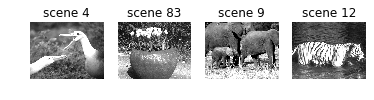

In [20]:
cell = ns_cells.iloc[0] 

exp_id = boc.get_ophys_experiments(experiment_container_ids=[cell['experiment_container_id']], stimuli = [stim_info.NATURAL_SCENES])

data_set = boc.get_ophys_experiment_data(exp_id[0]['id'])

scene_nums = [4, 83, 9, 12]

# read in the array of images
scenes = data_set.get_stimulus_template('natural_scenes')
stim_table = data_set.get_stimulus_table(stim_info.NATURAL_SCENES)
# display a couple of the scenes

fig, axes = plt.subplots(1,len(scene_nums))
for ax,scene in zip(axes, scene_nums):
    ax.imshow(scenes[scene,:,:], cmap='gray')
    ax.set_axis_off()
    ax.set_title('scene %d' % scene)
    

In [21]:
cell

area                                     VISp
cell_specimen_id                    517397377
dsi_dg                                1.17643
experiment_container_id             511498742
imaging_depth                             350
osi_dg                                1.31767
osi_sg                                1.07087
p_dg                               0.00728876
p_ns                              1.42935e-07
p_sg                              1.55662e-12
pref_dir_dg                               135
pref_image_ns                             111
pref_ori_sg                               120
pref_phase_sg                            0.75
pref_sf_sg                               0.04
pref_tf_dg                                  2
time_to_peak_ns                       0.29925
time_to_peak_sg                       0.29925
tld1_id                             177837516
tld1_name                      Scnn1a-Tg3-Cre
tld2_id                             177837320
tld2_name                         

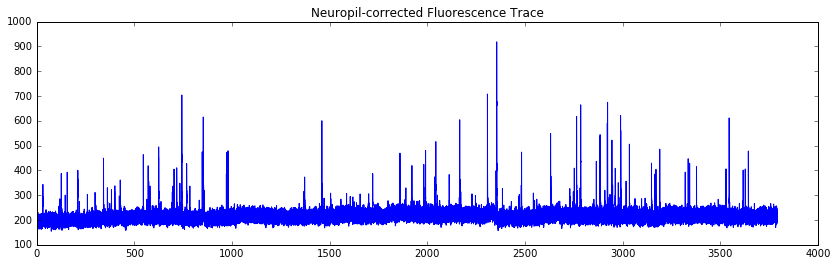

In [22]:
csid = cell['cell_specimen_id']

time, corrected_traces = data_set.get_corrected_fluorescence_traces(cell_specimen_ids=[csid])

plt.figure(figsize=(14,4))
plt.title("Neuropil-corrected Fluorescence Trace")
plt.plot(time, corrected_traces[0])
plt.show()


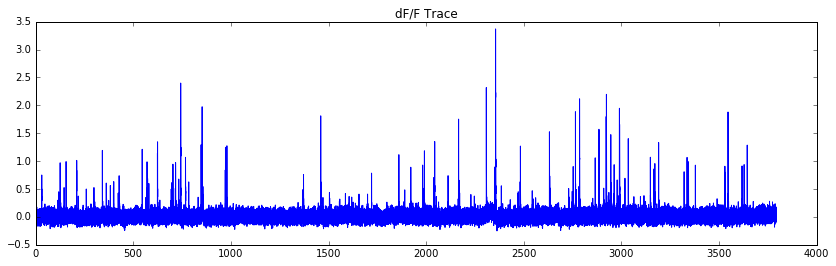

In [23]:
from allensdk.brain_observatory.dff import compute_dff

plt.figure(figsize=(14,4))
plt.title("dF/F Trace")
dff = compute_dff(np.array(corrected_traces))
plt.plot(time, dff[0,:])
plt.show()


In [195]:
#zscore scenes
m = np.mean(scenes)
sig = np.std(scenes)

scenes = (scenes - m)/sig

In [196]:
from sklearn.decomposition import PCA

model = PCA()
scenes = model.fit_transform(scenes.reshape([len(scenes), -1]))


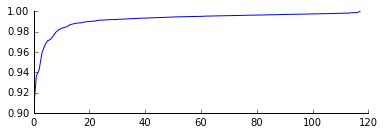

In [197]:
ax = plt.subplot(211)
plt.plot(1 - model.explained_variance_ratio_)
simpleaxis(ax)

In [165]:
#we make the design matrix, and corresponding dff array - using the stimulus table to tell us when a natural image was presented.
#dont need this cell when doing things the other way with images as trials

import cv2

stim_array = []
dff_array = []
im_array = []

for index, row in stim_table.iterrows():        
    stim_array.append(scenes[row.frame])
    dff_array.append(np.average(dff[0, row['start']:row['end']]))
    im_array.append(row.frame)
    
stim_array = np.array(stim_array)

In [168]:
stim_array[i-2:i + 1].reshape([1, -1]).shape

(1, 171)

In [169]:
stim_array_more = []

for i in range(0, len(stim_array)):
    if i < 2:
        stim_array_more.append(np.zeros([171]))
    else:
        temp = np.squeeze(stim_array[i-2:i + 1].reshape([-1]))
        stim_array_more.append(temp)


stim_array_ = np.array(stim_array_more)

print stim_array_.shape

(5950, 171)


In [24]:
#each stimulus is shown 50x, for 7 frames  (or occasionally 8 frames but here we only consider the first 7 frames)
#want a tensor that's data = N_images x N_trial x length_trial

N_images = 118
N_trials = 50
trial_length = 7
trial_counter = np.zeros(118)

data_tensor = np.zeros([N_images, N_trials, trial_length])

for index, row in stim_table.iterrows():
    if (row['frame'] == -1):
        pass
    else:
        data_tensor[row['frame'], trial_counter[row['frame']], : ] = (dff[0, row['start']:row['end']])[0:7]
        trial_counter[row['frame']] += 1

/Users/ameliachristensen/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [25]:
trial_av = np.mean(data_tensor, axis = 1)
trial_std = np.std(data_tensor, axis = 1) / np.sqrt(data_tensor.shape[1])

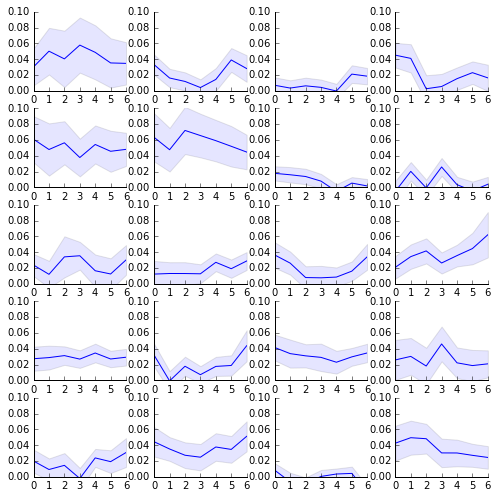

In [32]:
num_rows, num_cols = 5, 4

x = range(0, trial_length)

fig = plt.figure(figsize=(7,7))
gs = gridspec.GridSpec(num_rows, num_cols, wspace=0.0)

ax = [plt.subplot(gs[i]) for i in range(num_rows*num_cols)]
gs.update(hspace=0)
gs.tight_layout(fig, h_pad=0,w_pad=0)

for i in range(num_rows*num_cols):
    ax[i].plot(x, trial_av[i, :], 'b')
    ax[i].fill_between(x, trial_av[i, :]-trial_std[i, :], trial_av[i, :]+trial_std[i, :], alpha = .1, facecolor = 'blue') 
    ax[i].set_ylim([0, .1])
    simpleaxis(ax[i])   
plt.show()

In [138]:
test_size = 10

img_idx = np.random.permutation(range(0, N_images))

test_tensor = data_tensor[img_idx[0:15]].flatten()[:, np.newaxis]
train_tensor = data_tensor[img_idx[15:]].flatten()[:, np.newaxis]

In [139]:
#make stimulus arrays

import cv2
A = [cv2.resize(scenes[i], (20, 20)) for i in img_idx]
A = np.array(A).reshape(118, 20, 20)

_scenes = np.repeat(A, trial_length*N_trials, axis = 0)

test_scenes = _scenes[0:15*trial_length*N_trials].reshape([-1, 20*20])
train_scenes = _scenes[15*trial_length*N_trials:].reshape([-1, 20*20])

In [93]:
print test_scenes.shape, train_scenes.shape, test_tensor.shape, train_tensor.shape, len(stim_array), len(dff_array)

(5355, 400) (36771, 400) (5355, 1) (36771, 1) 41790 41790


0.206526647432


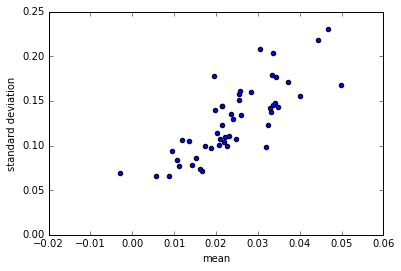

In [28]:
data_tensor = data_tensor.reshape(N_trials, N_images*trial_length)

std_array = np.std(data_tensor, axis = 1)
mean_array = np.mean(data_tensor, axis = 1)

plt.scatter(mean_array, std_array)
plt.ylabel('standard deviation')
plt.xlabel('mean')
slope, intercept, r_value, p_value, std_err = linregress(std_array, mean_array)

print slope

In [88]:
#DEPRECATED

dff_array = np.array(dff_array)[:, np.newaxis]
#stim_array = np.array(stim_array).reshape([41790, 20*20])


In [90]:
#DEPRECATED

#stim_array = np.column_stack((stim_array, np.ones(41887)))
stim_array = np.column_stack((stim_array, dff_array))

print len(stim_array)


5950


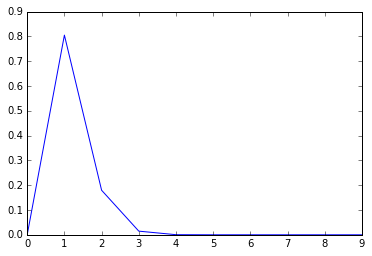

ValueError: object too deep for desired array

In [89]:
from scipy.stats import norm

n = 20
basis = norm.pdf(range(0, n), loc = n/2, scale = n/20)

basis = basis[10:]
basis[0:1] = 0
basis /= sum(basis)

plt.plot( basis)
plt.show()


#l, n = stim_array.shape

#for i in range(n):
#    stim_array[:, i] = np.squeeze(np.convolve(stim_array[:, i], basis)[0:l])
 
    
dff_array = np.convolve(dff_array, basis)[0:len(dff_array)] 

In [170]:
#DEPRECATED

from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test, im_train, im_test = train_test_split(np.array(stim_array_), np.array(dff_array), im_array)

#X_train, X_test, y_train, y_test = train_scenes, test_scenes, train_tensor, test_tensor


(5950, 171)

In [171]:
#this takes a long time...

weight_init = np.linalg.pinv(X_train).dot(y_train)

(171,)

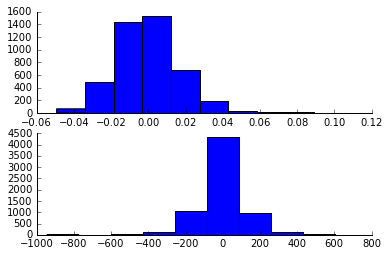

In [172]:
ax = plt.subplot(211)
plt.hist(X_train.dot(weight_init).flatten())
simpleaxis(ax)


ax = plt.subplot(212)
plt.hist(scenes.flatten())
simpleaxis(ax)

In [175]:
import tensorflow as tf

exp_model = gm.exponential_GLM(weight_init.shape[0], weight_init[:,np.newaxis], alpha = 100, reg = 'l2',  
                               non_lin = tf.exp, lr = .001, bias_init = 0, 
                            scale_init= 1, train_params = True)

L, l  = exp_model.fit(X_train, y_train[:, np.newaxis], X_test, y_test[:, np.newaxis], batch_size = 10000, max_iters=40)


0%                          100%
[******************************] | ETA: 00:00:00
Total time elapsed: 00:00:01


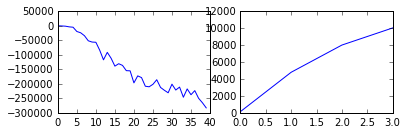

In [176]:
plt.subplot(221)
plt.plot(L)
plt.subplot(222)
plt.plot(l)



In [177]:
w, o, s  = exp_model.get_params()


In [178]:
w.shape


(171, 1)

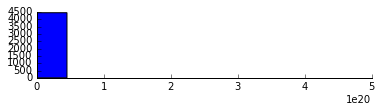

In [179]:
ax = plt.subplot(311)
plt.hist(np.exp(X_train.dot(w).flatten()))
simpleaxis(ax)


In [180]:
s

0.96942592

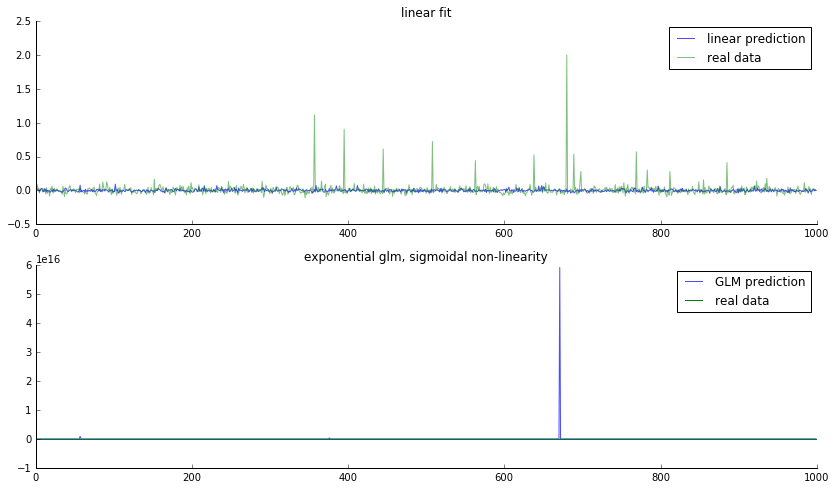

In [181]:
from glm_utils import *

plt.figure(figsize = [14, 8])

ax = plt.subplot(211)
plt.plot((X_test.dot(weight_init))[0:1000], alpha = .7, c = 'b', label = 'linear prediction')
plt.plot(y_test[0:1000], 'g', alpha = .5, label = 'real data')
plt.title('linear fit')
plt.legend()
simpleaxis(ax)

ax = plt.subplot(212)
plt.plot(cond_int(np.exp, w, X_test, s, o)[0:1000], alpha = .7, c = 'b', label = 'GLM prediction')
plt.plot(y_test[0:1000], 'g', label = 'real data')
plt.legend()
plt.title('exponential glm, sigmoidal non-linearity')
simpleaxis(ax)

1.43923231365e-05


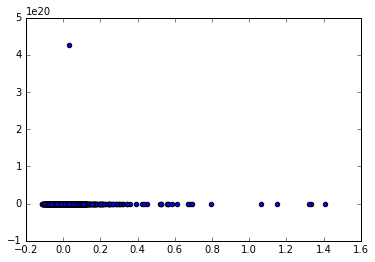

In [182]:
plt.scatter(y_train, cond_int(np.exp, w, X_train, s, o))
slope, intercept, r_value, p_value, std_err = linregress(np.squeeze(cond_int(np.exp, w, X_test, s, o)), np.squeeze(y_test))


print r_value**2

0.00147681618784


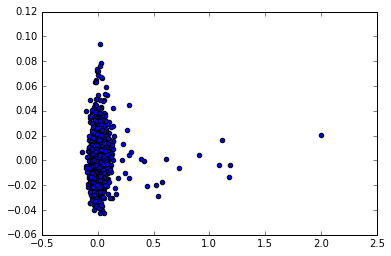

In [183]:
plt.scatter(y_test, X_test.dot(weight_init))

slope, intercept, r_value, p_value, std_err = linregress(np.squeeze(X_test.dot(weight_init)), np.squeeze(y_test))
print r_value**2



Now we start worrying about fitting the data with a poisson process. 

In [1083]:
import pyfnnd as oopsi

In [1111]:
n, c, ll, th = oopsi.deconvolve(np.squeeze(dff_array), dt = 1.0/30, tau = .8)

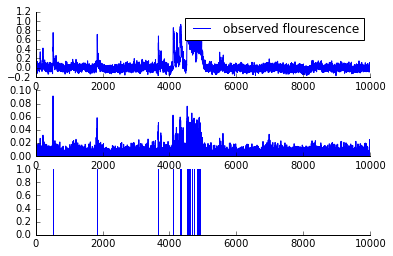

In [1119]:
ax = plt.subplot(311)
plt.plot(dff_array[0:10000], label = 'observed flourescence')
plt.legend()
simpleaxis(ax)

ax = plt.subplot(312)
plt.plot(n[0:10000], label = 'conditional intensity best guess spike train')
#plt.legend()
simpleaxis(ax)

spikes = (n > .05)[:, np.newaxis]

ax = plt.subplot(313)
plt.stem(spikes[0:10000], linewidth = .1, markerfmt = ' ')
simpleaxis(ax)

In [1120]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(stim_array, spikes, test_size = .25, random_state = 0)

weight_init = np.linalg.pinv(X_train).dot(y_train)

In [1130]:
poi_model = gm.poisson_GLM(401, weight_init.reshape([401, 1]), reg = 'l1', alpha = 0.001, 
                               non_lin = tf.exp, lr = .001, bias_init = 0, 
                            scale_init= .4, train_params = True)

training_loss, test_loss  = poi_model.fit(X_train, y_train, X_test, y_test, batch_size = 10000, max_iters=1000)

0%                          100%
[******************************] | ETA: 00:00:00
Total time elapsed: 00:01:37


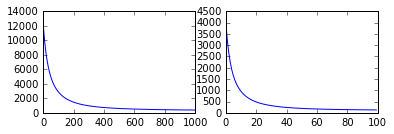

In [1131]:
plt.subplot(221)
plt.plot(training_loss)
plt.subplot(222)
plt.plot(test_loss)


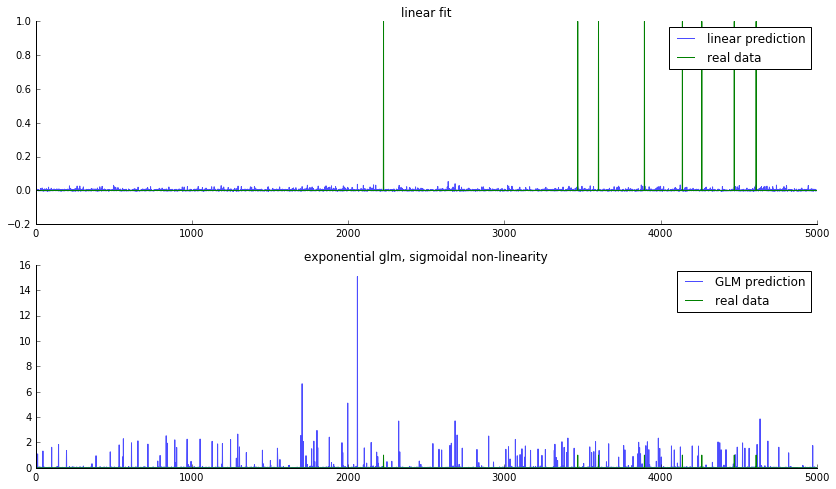

In [1133]:
from glm_utils import *

plt.figure(figsize = [14, 8])

ax = plt.subplot(211)
plt.plot((X_test.dot(weight_init))[0:5000], alpha = .7, c = 'b', label = 'linear prediction')
plt.plot(y_test[0:5000], 'g', label = 'real data')
plt.title('linear fit')
plt.legend()
simpleaxis(ax)

ax = plt.subplot(212)
plt.plot(cond_int(np.exp, w, X_test, s, o)[0:5000], alpha = .7, c = 'b', label = 'GLM prediction')
plt.plot(y_test[0:5000], 'g', label = 'real data')
plt.legend()
plt.title('exponential glm, sigmoidal non-linearity')
simpleaxis(ax)

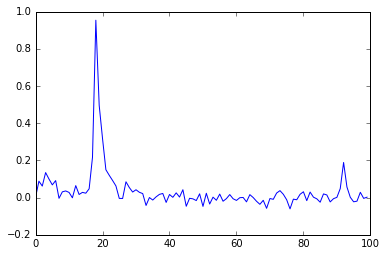

In [108]:
plt.plot(dff_array[0:100])